<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Computing-AP1-and-Nr5a2-Scores" data-toc-modified-id="Computing-AP1-and-Nr5a2-Scores-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing AP1 and Nr5a2 Scores</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter, OrderedDict
from matplotlib import patches as mpatches

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import os

import sklearn.manifold
from sklearn.decomposition import PCA

#import phenograph

from scipy.sparse import csr_matrix, find, issparse

import scanpy as scanpy
import time
import scipy

In [2]:
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
palette =  {0:"#000000",1:"#010067",2:"#D5FF00",3:"#FF0056",4:"#9E008E", 5:"#0E4CA1", 6:"#FFE502", 7:"#005F39", 8:"#00FF00", 9:"#95003A",10:"#FF937E",
          11:"#A42400", 12:"#001544", 13:"#91D0CB",14:"#620E00",15:"#6B6882",16:"#0000FF",17:"#007DB5",18:"#6A826C",19:"#00AE7E",20:"#C28C9F",
          21:"#BE9970",22:"#008F9C",23:"#5FAD4E",24:"#FF0000", 25:"#FF00F6",26:"#FF029D",27:"#683D3B",28:"#FF74A3",29:"#968AE8",30:"#98FF52",
          31:"#A75740",32:"#01FFFE",33:"#FFEEE8",34:"#FE8900",35:"#BDC6FF",36:"#01D0FF",37:"#BB8800",38:"#7544B1",39:"#A5FFD2",40:"#FFA6FE",
          41:"#774D00", 42:"#7A4782", 43:"#263400", 44:"#004754", 45:"#43002C", 46:"#B500FF", 47:"#FFB167", 48:"#FFDB66", 49:"#90FB92",
          50:"#7E2DD2", 51:"#BDD393", 52:"#E56FFE", 53:"#DEFF74", 54:"#00FF78", 55:"#009BFF", 56:"#006401", 57:"#0076FF", 58:"#85A900", 59:"#00B917",
          60:"#788231", 61:"#00FFC6", 62:"#FF6E41", 63:"#E85EBE"}
palette[70] = "#FFFFFF"

# Loading Data

In [4]:
sample = ''

path_h5 = 'data'
suffix_h5  = 'filtered_peak_bc_matrix.h5'

In [5]:
adata = scanpy.read_10x_h5(path_h5 + sample + "/" + suffix_h5, genome=None, gex_only=False)

In [6]:
peaks = np.array(adata.var['gene_ids'])
data = adata.X.copy()

In [7]:
sample_ids = np.array(list(adata.obs.index))
sample_ids = [sample.split("-")[1] for sample in sample_ids]
cell_barcodes = [sample.split("-")[0] for sample in np.array(list(adata.obs.index))]

In [8]:
#load saved files from previous analysis
a = pickle.load(open("data/clusters.p",'rb'))
keep_cells = pickle.load(open("data/filtered_cells.p",'rb'))
embedding = pd.read_csv("data/UMAP.csv").values

In [9]:
#remove filtered cells
sample_ids = np.array(sample_ids)[keep_cells]
cell_barcodes = np.array(cell_barcodes)[keep_cells]
data = scipy.sparse.csr_matrix(data.toarray()[keep_cells,:])
data_bin = scipy.sparse.csr_matrix((data.toarray()>0.0).astype(np.int_))

In [10]:
#creat dataframe from binary matrix
data_bin_df = pd.DataFrame(data_bin.toarray(),columns=peaks)

In [11]:
#re-cycled cluster merging code
c1 = [8]
c2 = [10,5]
c3 = [11]
c4 = [9,12]
c5 = [2,3,7]
c6 = [0,1,6,4]
c7 = [13]

def get_cells(clusters):
    return np.array([cell in clusters for cell in a])

clusters_merged = []
for clusters in [c1,c2,c3,c4,c5,c6,c7]:
    clusters_merged.append(np.where(get_cells(clusters))[0])
    
cells_clustersmerged = []
for cell in range(len(keep_cells)):
    cluster = [cell in clusters for clusters in clusters_merged]
    cells_clustersmerged.append(np.where(cluster)[0][0])

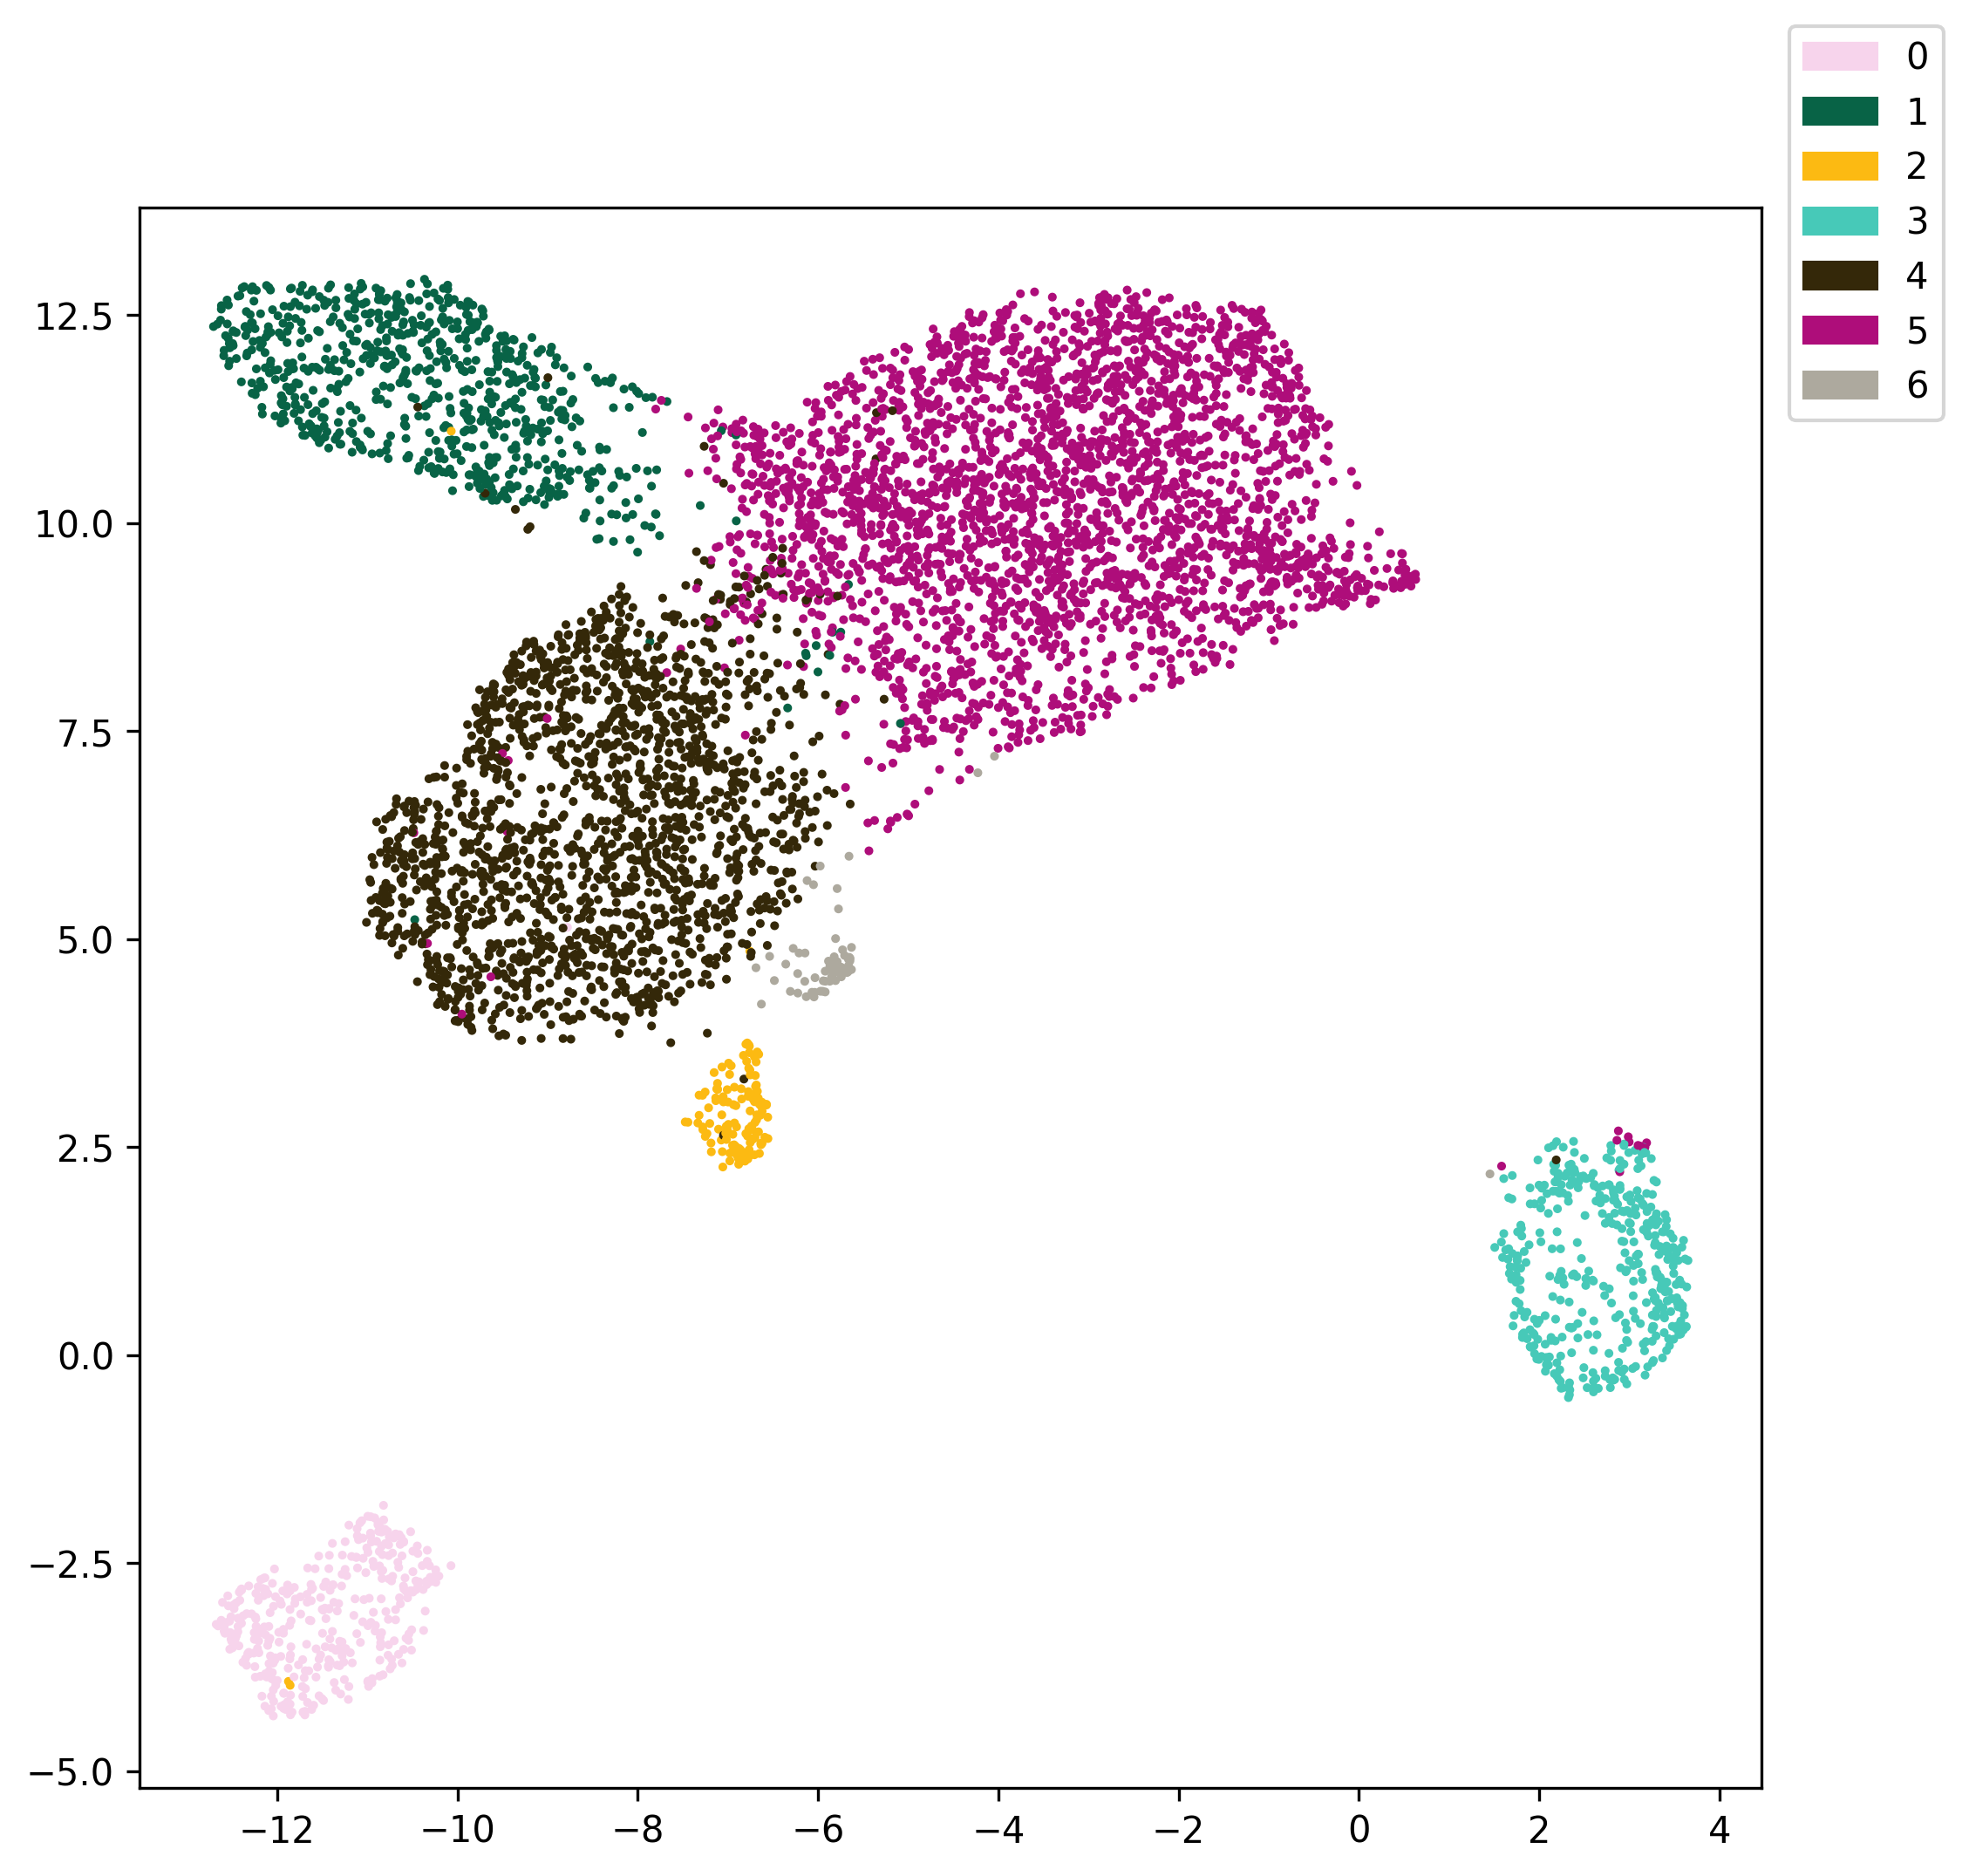

In [12]:
#check clusters
palette_1 = {0:"#F7D4EC",5:"#AE0D7A",2:"#FCBA12",3:"#47c9b8",4:"#342809",1:"#086346",6:"#ada99e"}
cells_clustersmerged_colors = [palette_1[i] for i in cells_clustersmerged]

fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=2, c=cells_clustersmerged_colors)

patches = []
for color in range(np.max(cells_clustersmerged)+1):
    patches.append(mpatches.Patch(color=palette_1[color],label=color))
plt.legend(handles=patches,loc=1,borderaxespad=-5)

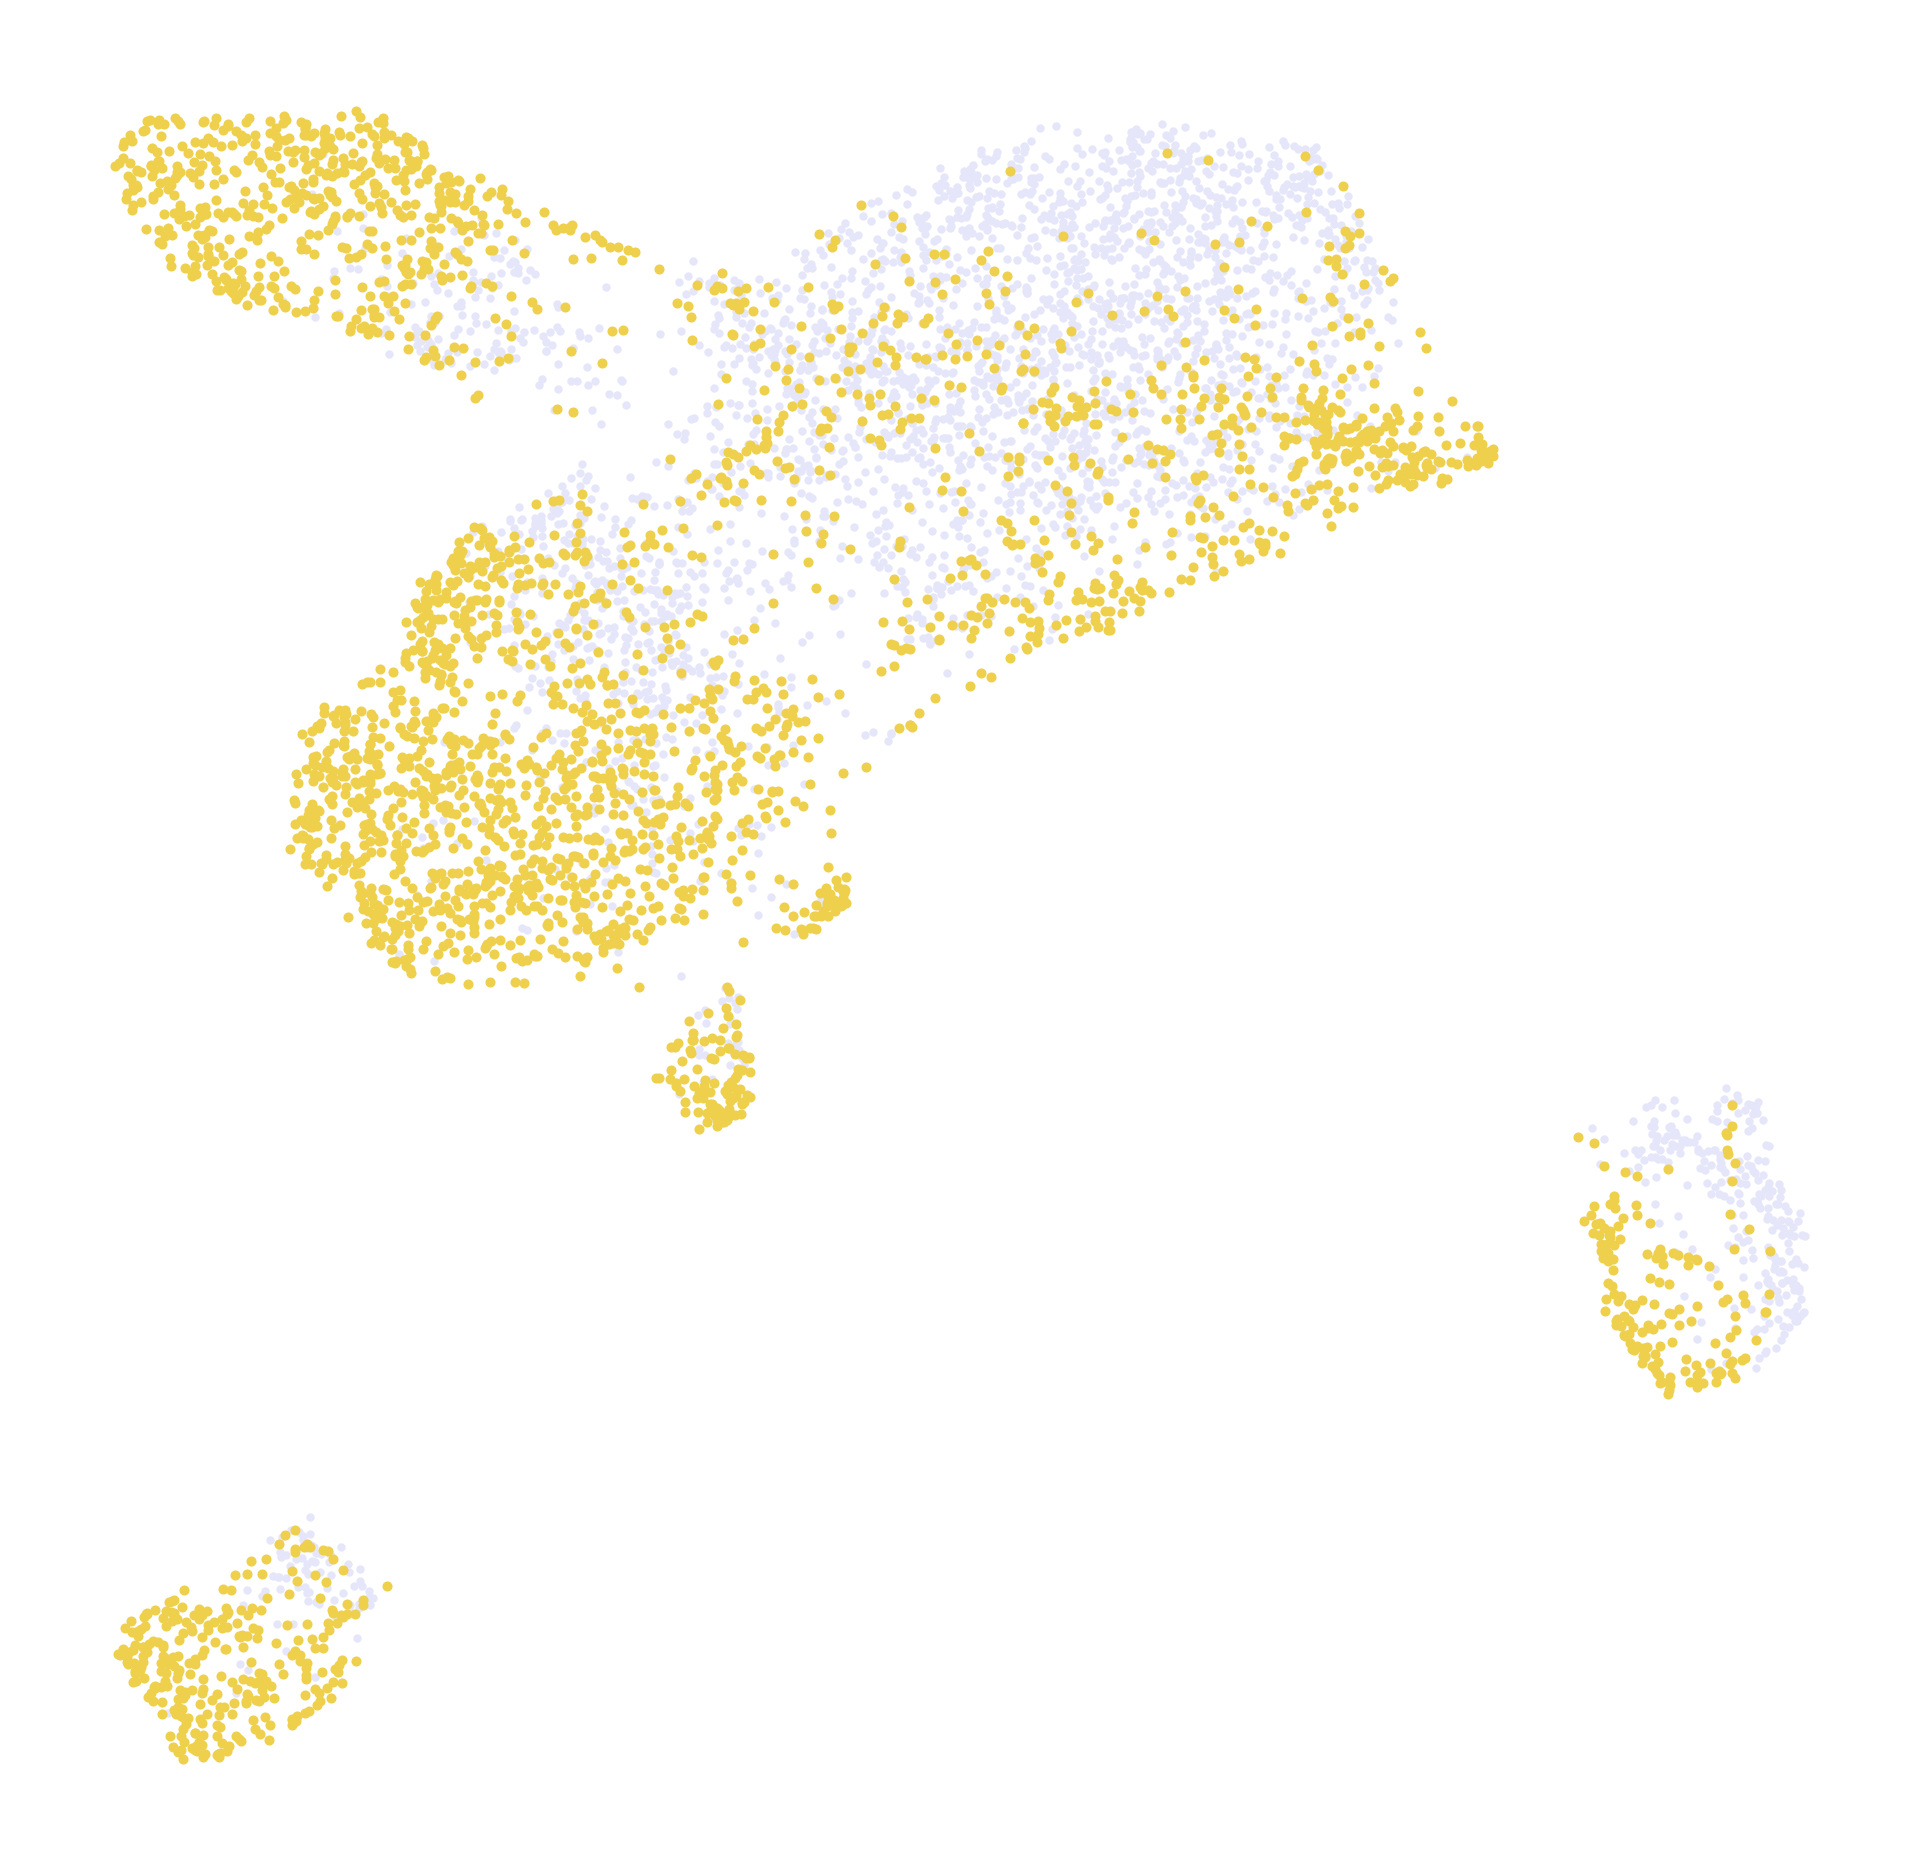

In [13]:
#PBS
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids=='2'],embedding[:,1][sample_ids=='2'],s=2, c="#EED04D")
ax.set_axis_off()

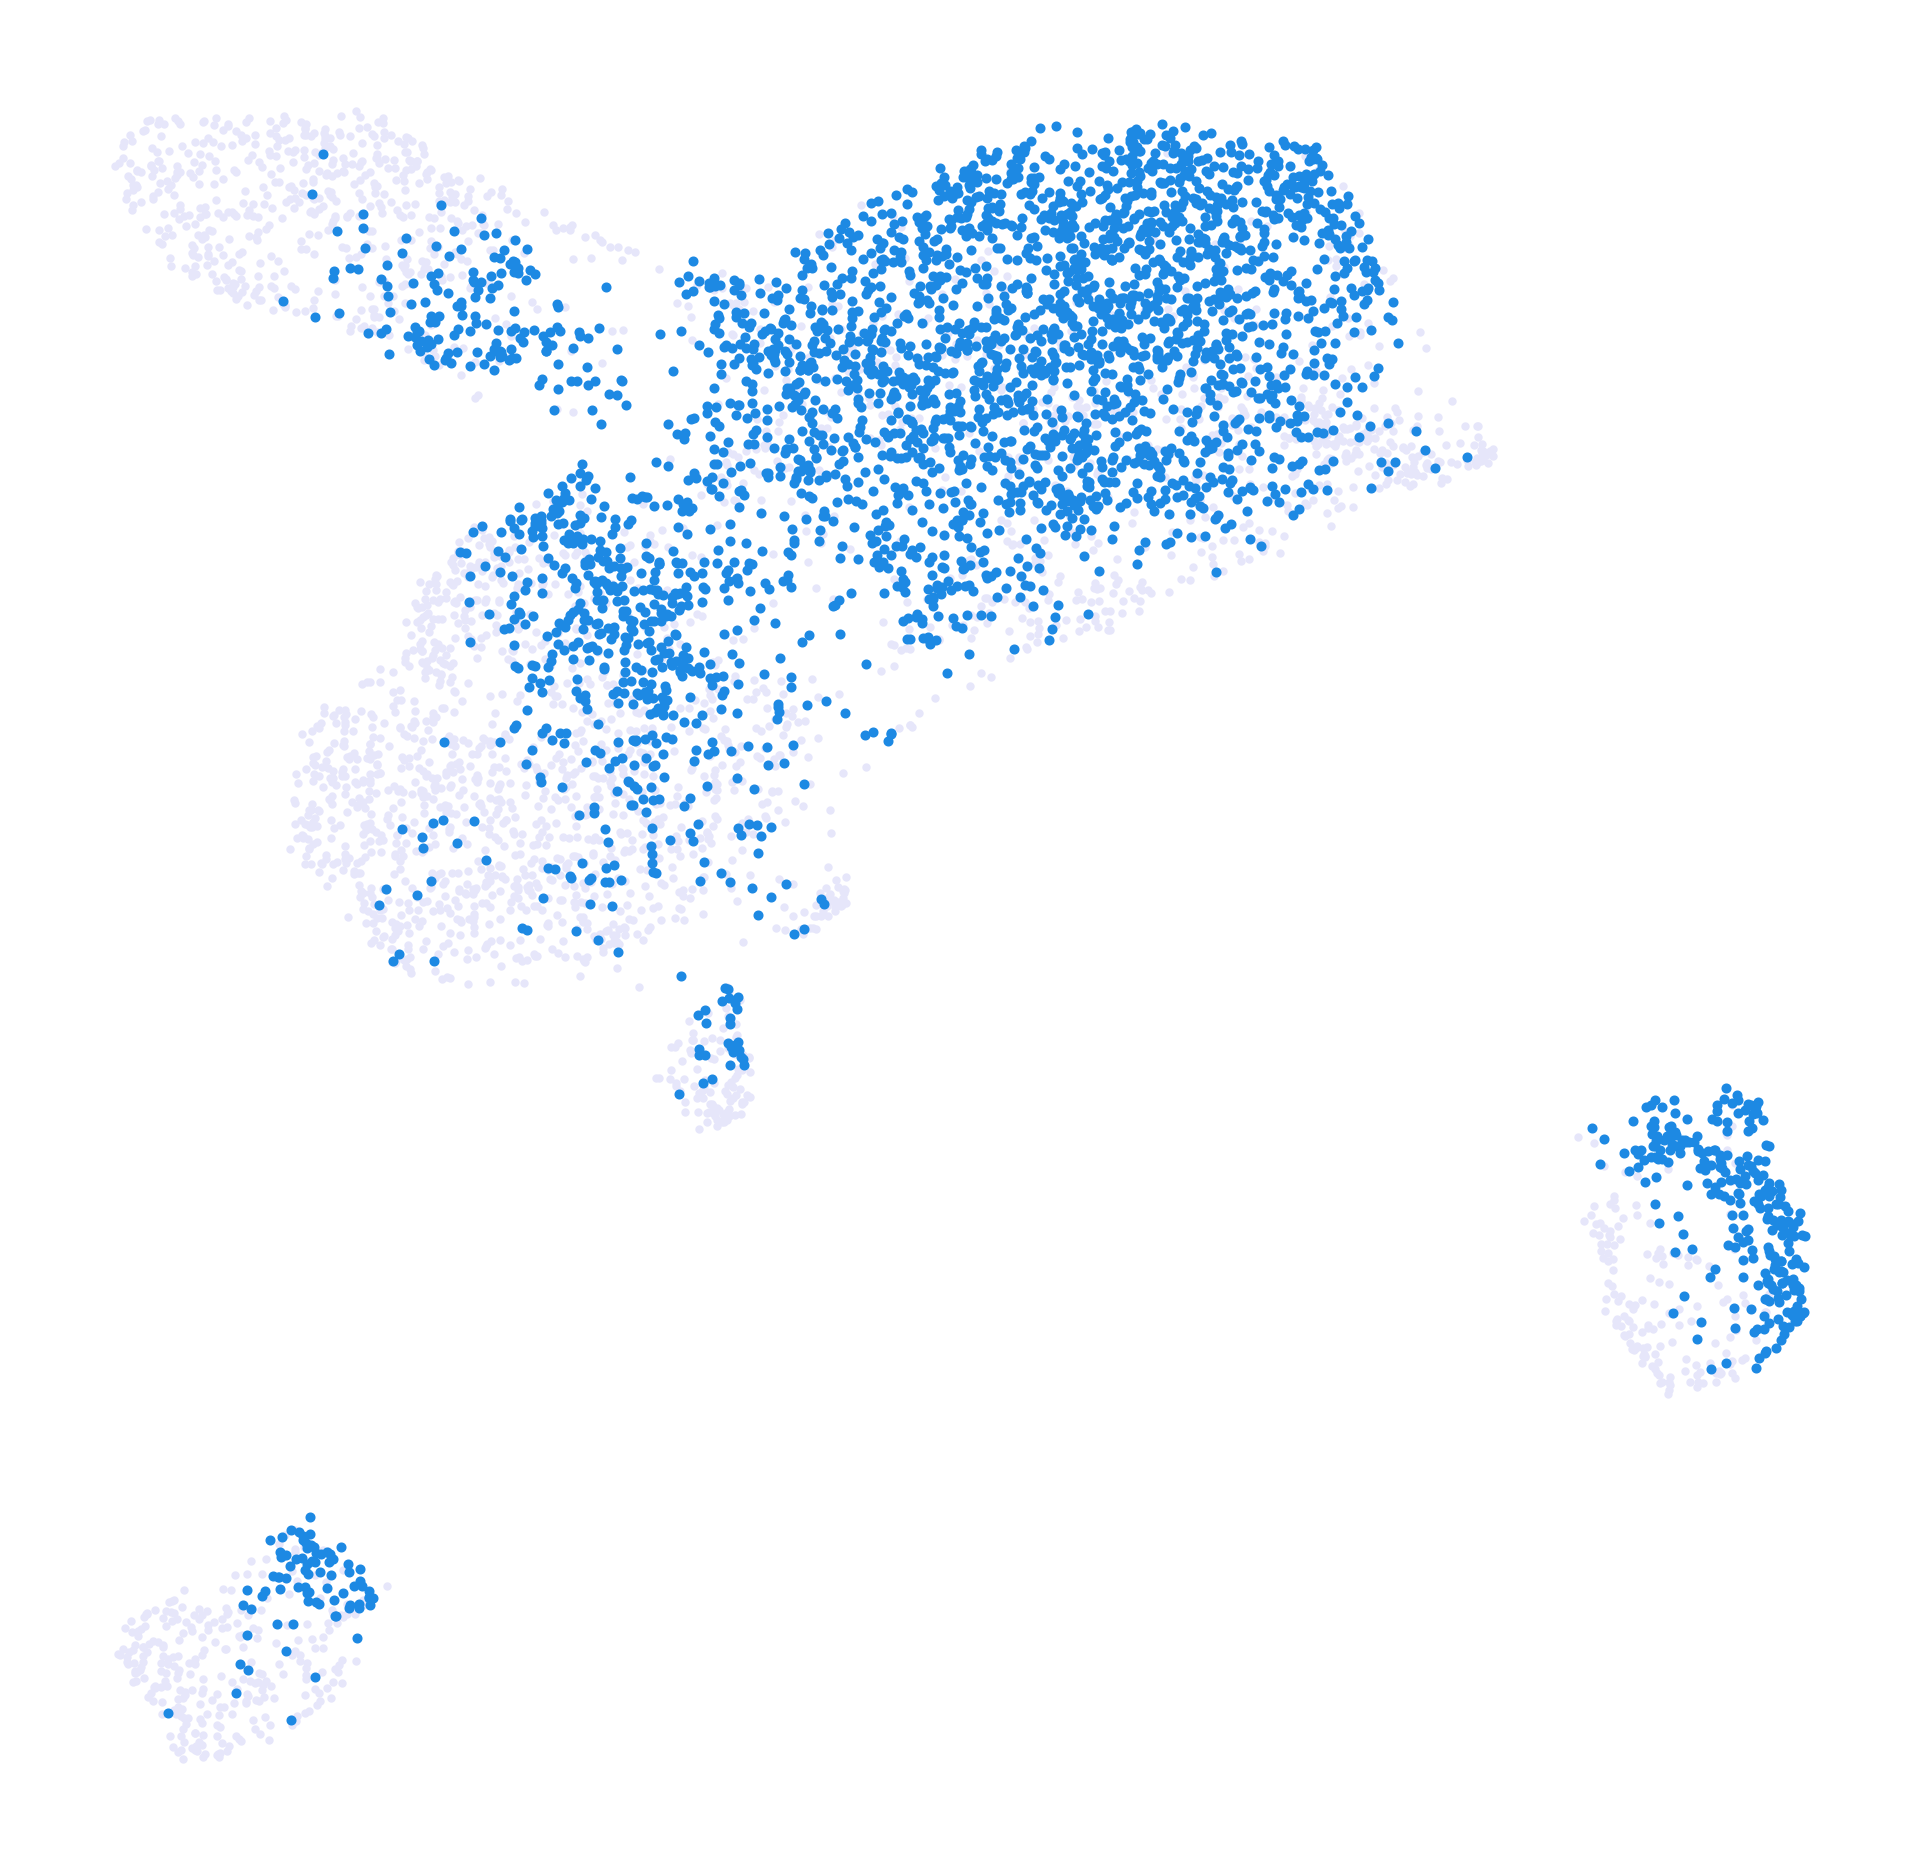

In [14]:
#injury
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids=='1'],embedding[:,1][sample_ids=='1'],s=2, c='#1D89E3')
ax.set_axis_off()

# Computing AP1 and Nr5a2 Scores

Scores computed as: $log(\frac{\text{open peaks with motif}}{\text{open peaks}} + pseudocount)$

In [15]:
total_peaks = np.array(data_bin.sum(1)).T[0]

In [16]:
from copy import deepcopy

def compute_score(file):
    tmp_ = pd.read_csv("../../../data/scATACseq/KateMerge_10bp/bulk_intersection/newmotifs_{}_fulloverlap.bed".format(file),
                                 sep='\t',header=None)
    #reformat peak names from bed file
    tmp_peaks = ["{}:{}-{}".format(tmp_.iloc[i][0],tmp_.iloc[i][1],tmp_.iloc[i][2]) for i in range(tmp_.shape[0])]
    #subset binarized data to TF peaks
    data_tmp = deepcopy(data_bin_df[tmp_peaks])
    #compute number of open peaks in set divided by total number of open peaks
    tmp_score = data_tmp.sum(1).values / total_peaks
    #log transform, all will be negative since this is a ratio
    return np.log(tmp_score+.0001)

In [17]:
#load peak sets for each TF
#repeat above for Nr5a2 set
file = 'T4_CLDN_Nr5a2ChIP'
tmp3 = compute_score(file)

file = 'T4_OPUP_AP1Motif+'
tmp2 = compute_score(file)

In [18]:
np.corrcoef(tmp2,tmp3)[0,1]

-0.4297452998265484

Text(0, 0.5, 'Nr5a2')

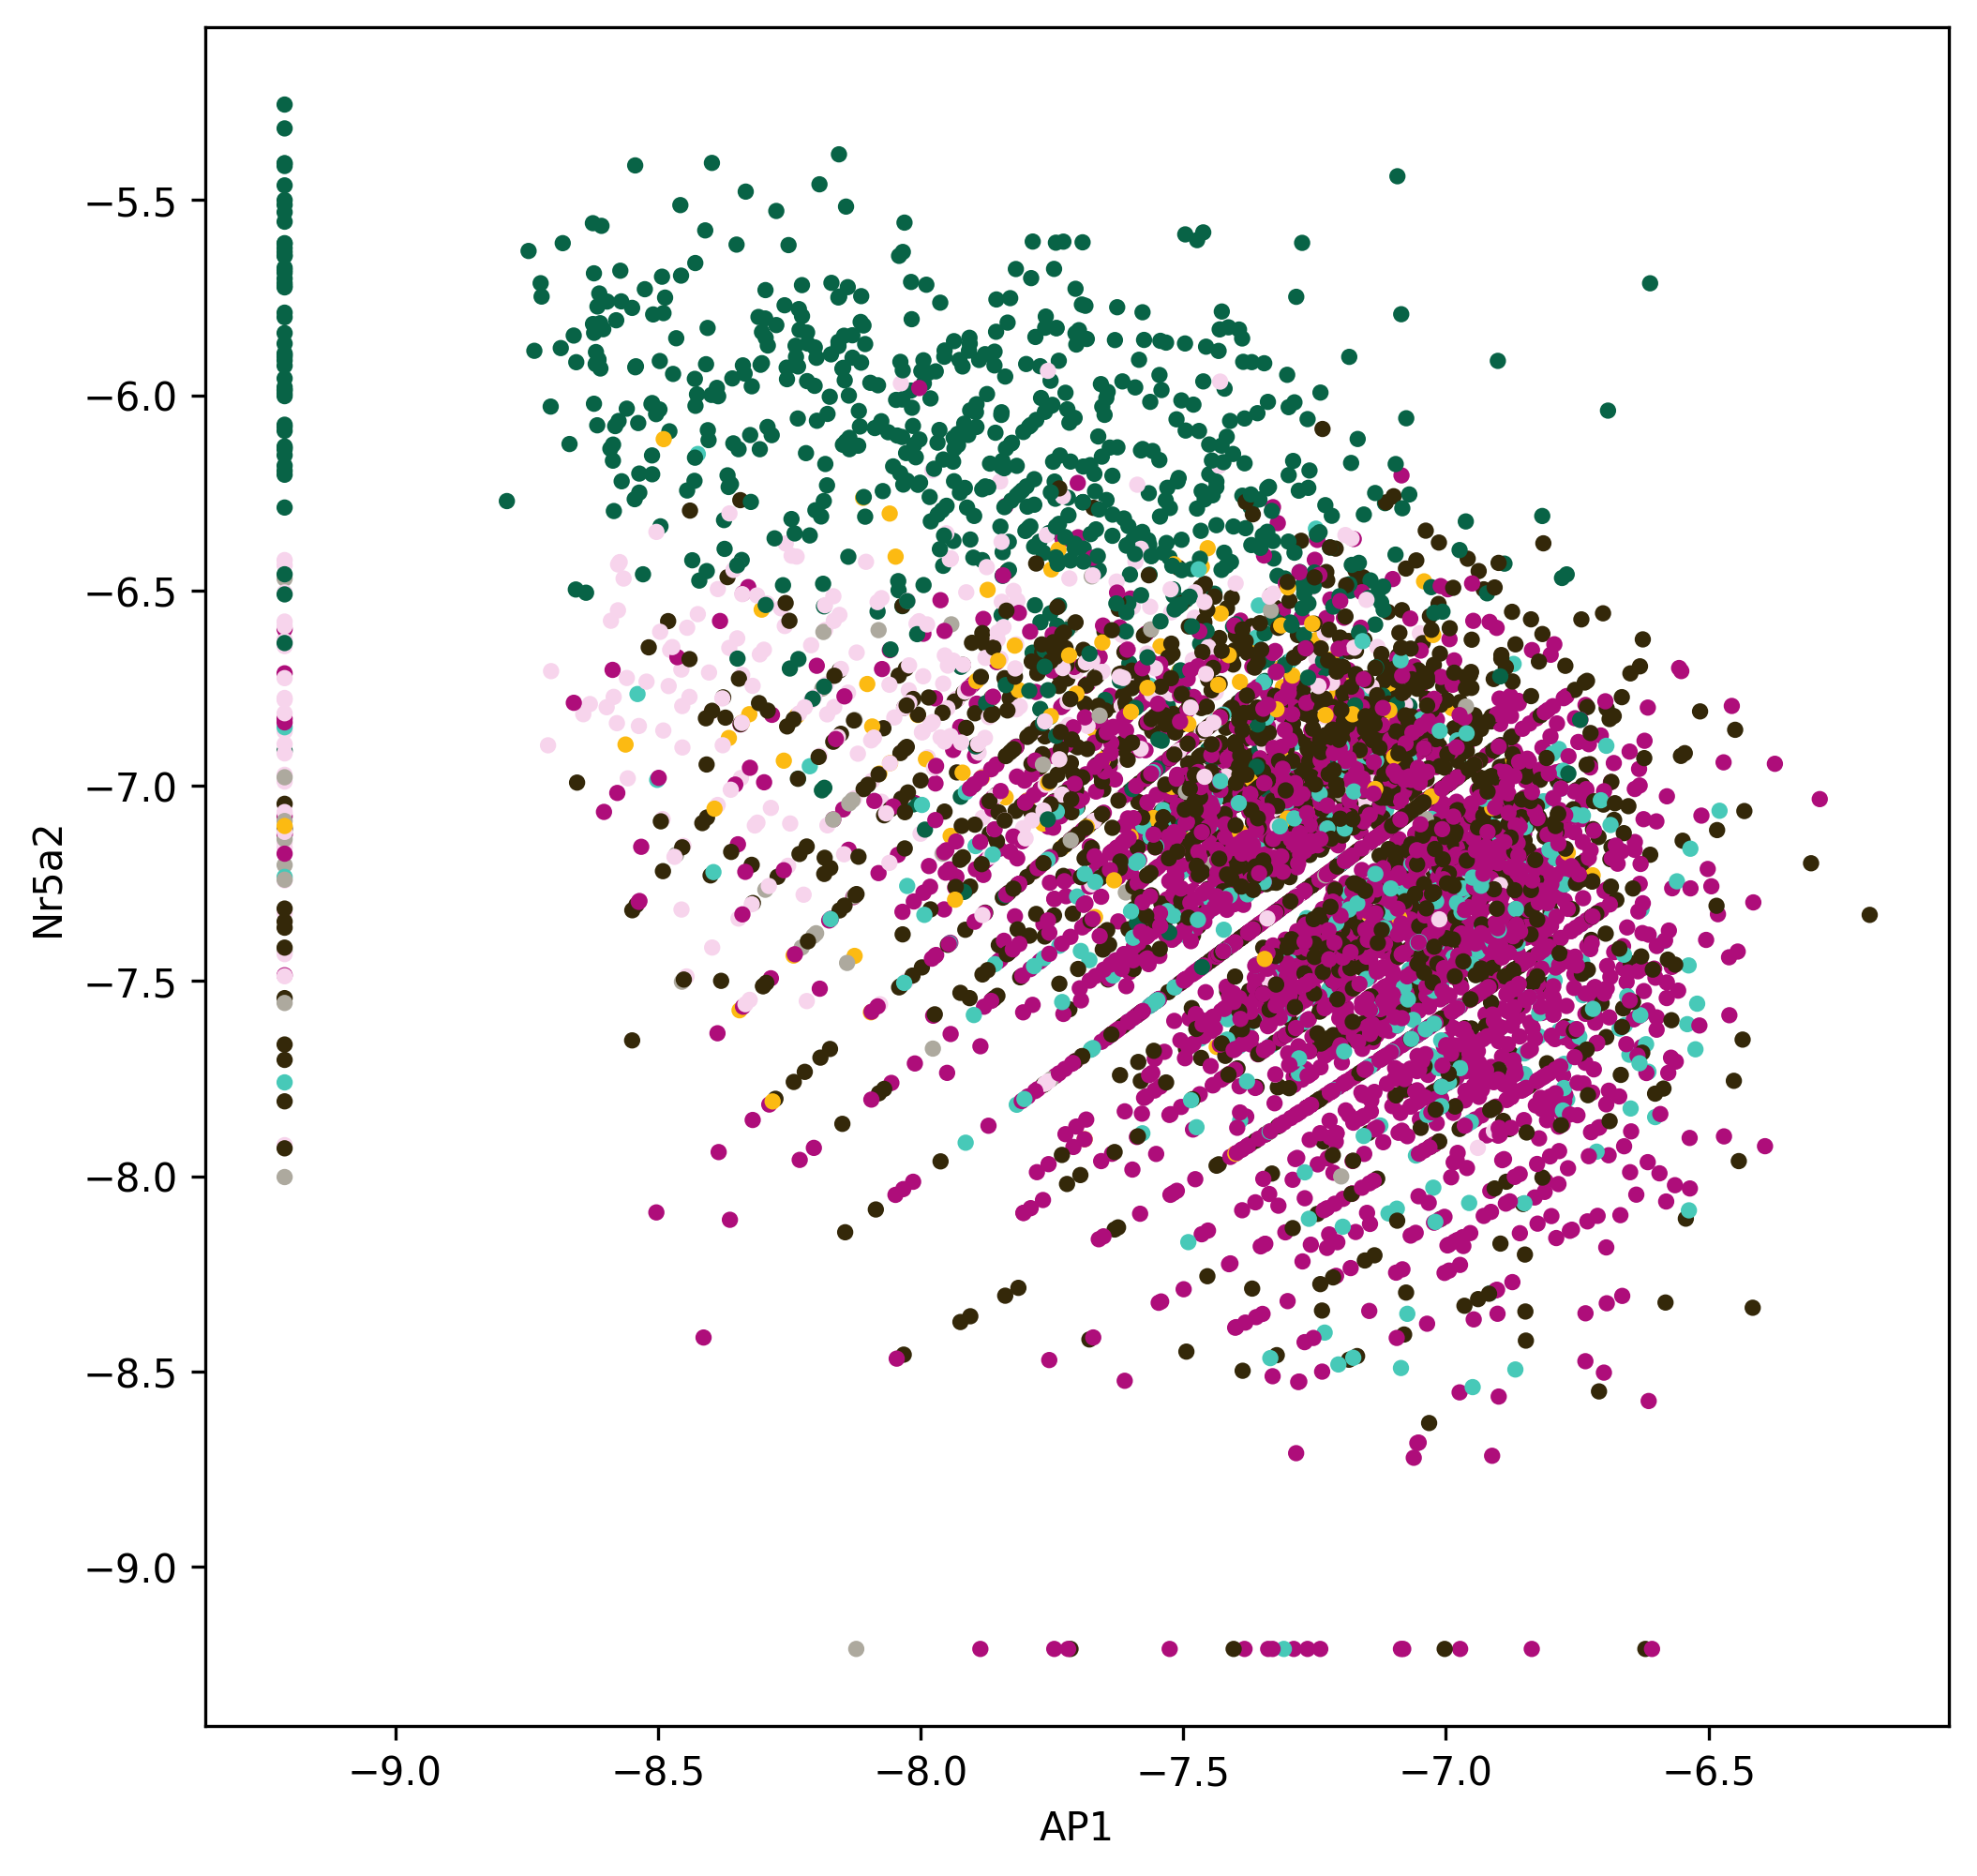

In [19]:
#visualize correlation of score
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(tmp2,tmp3,s=10,c=cells_clustersmerged_colors)
ax.set_xlabel("AP1")
ax.set_ylabel("Nr5a2")

In [20]:
#compute score
score = tmp3/tmp2
order = np.argsort(score) #ordering cells from least AP1 to most
mat = np.vstack((tmp2,tmp3)) #stacking AP1 over Nr5a2

Text(0, 0.5, 'Nr5a2')

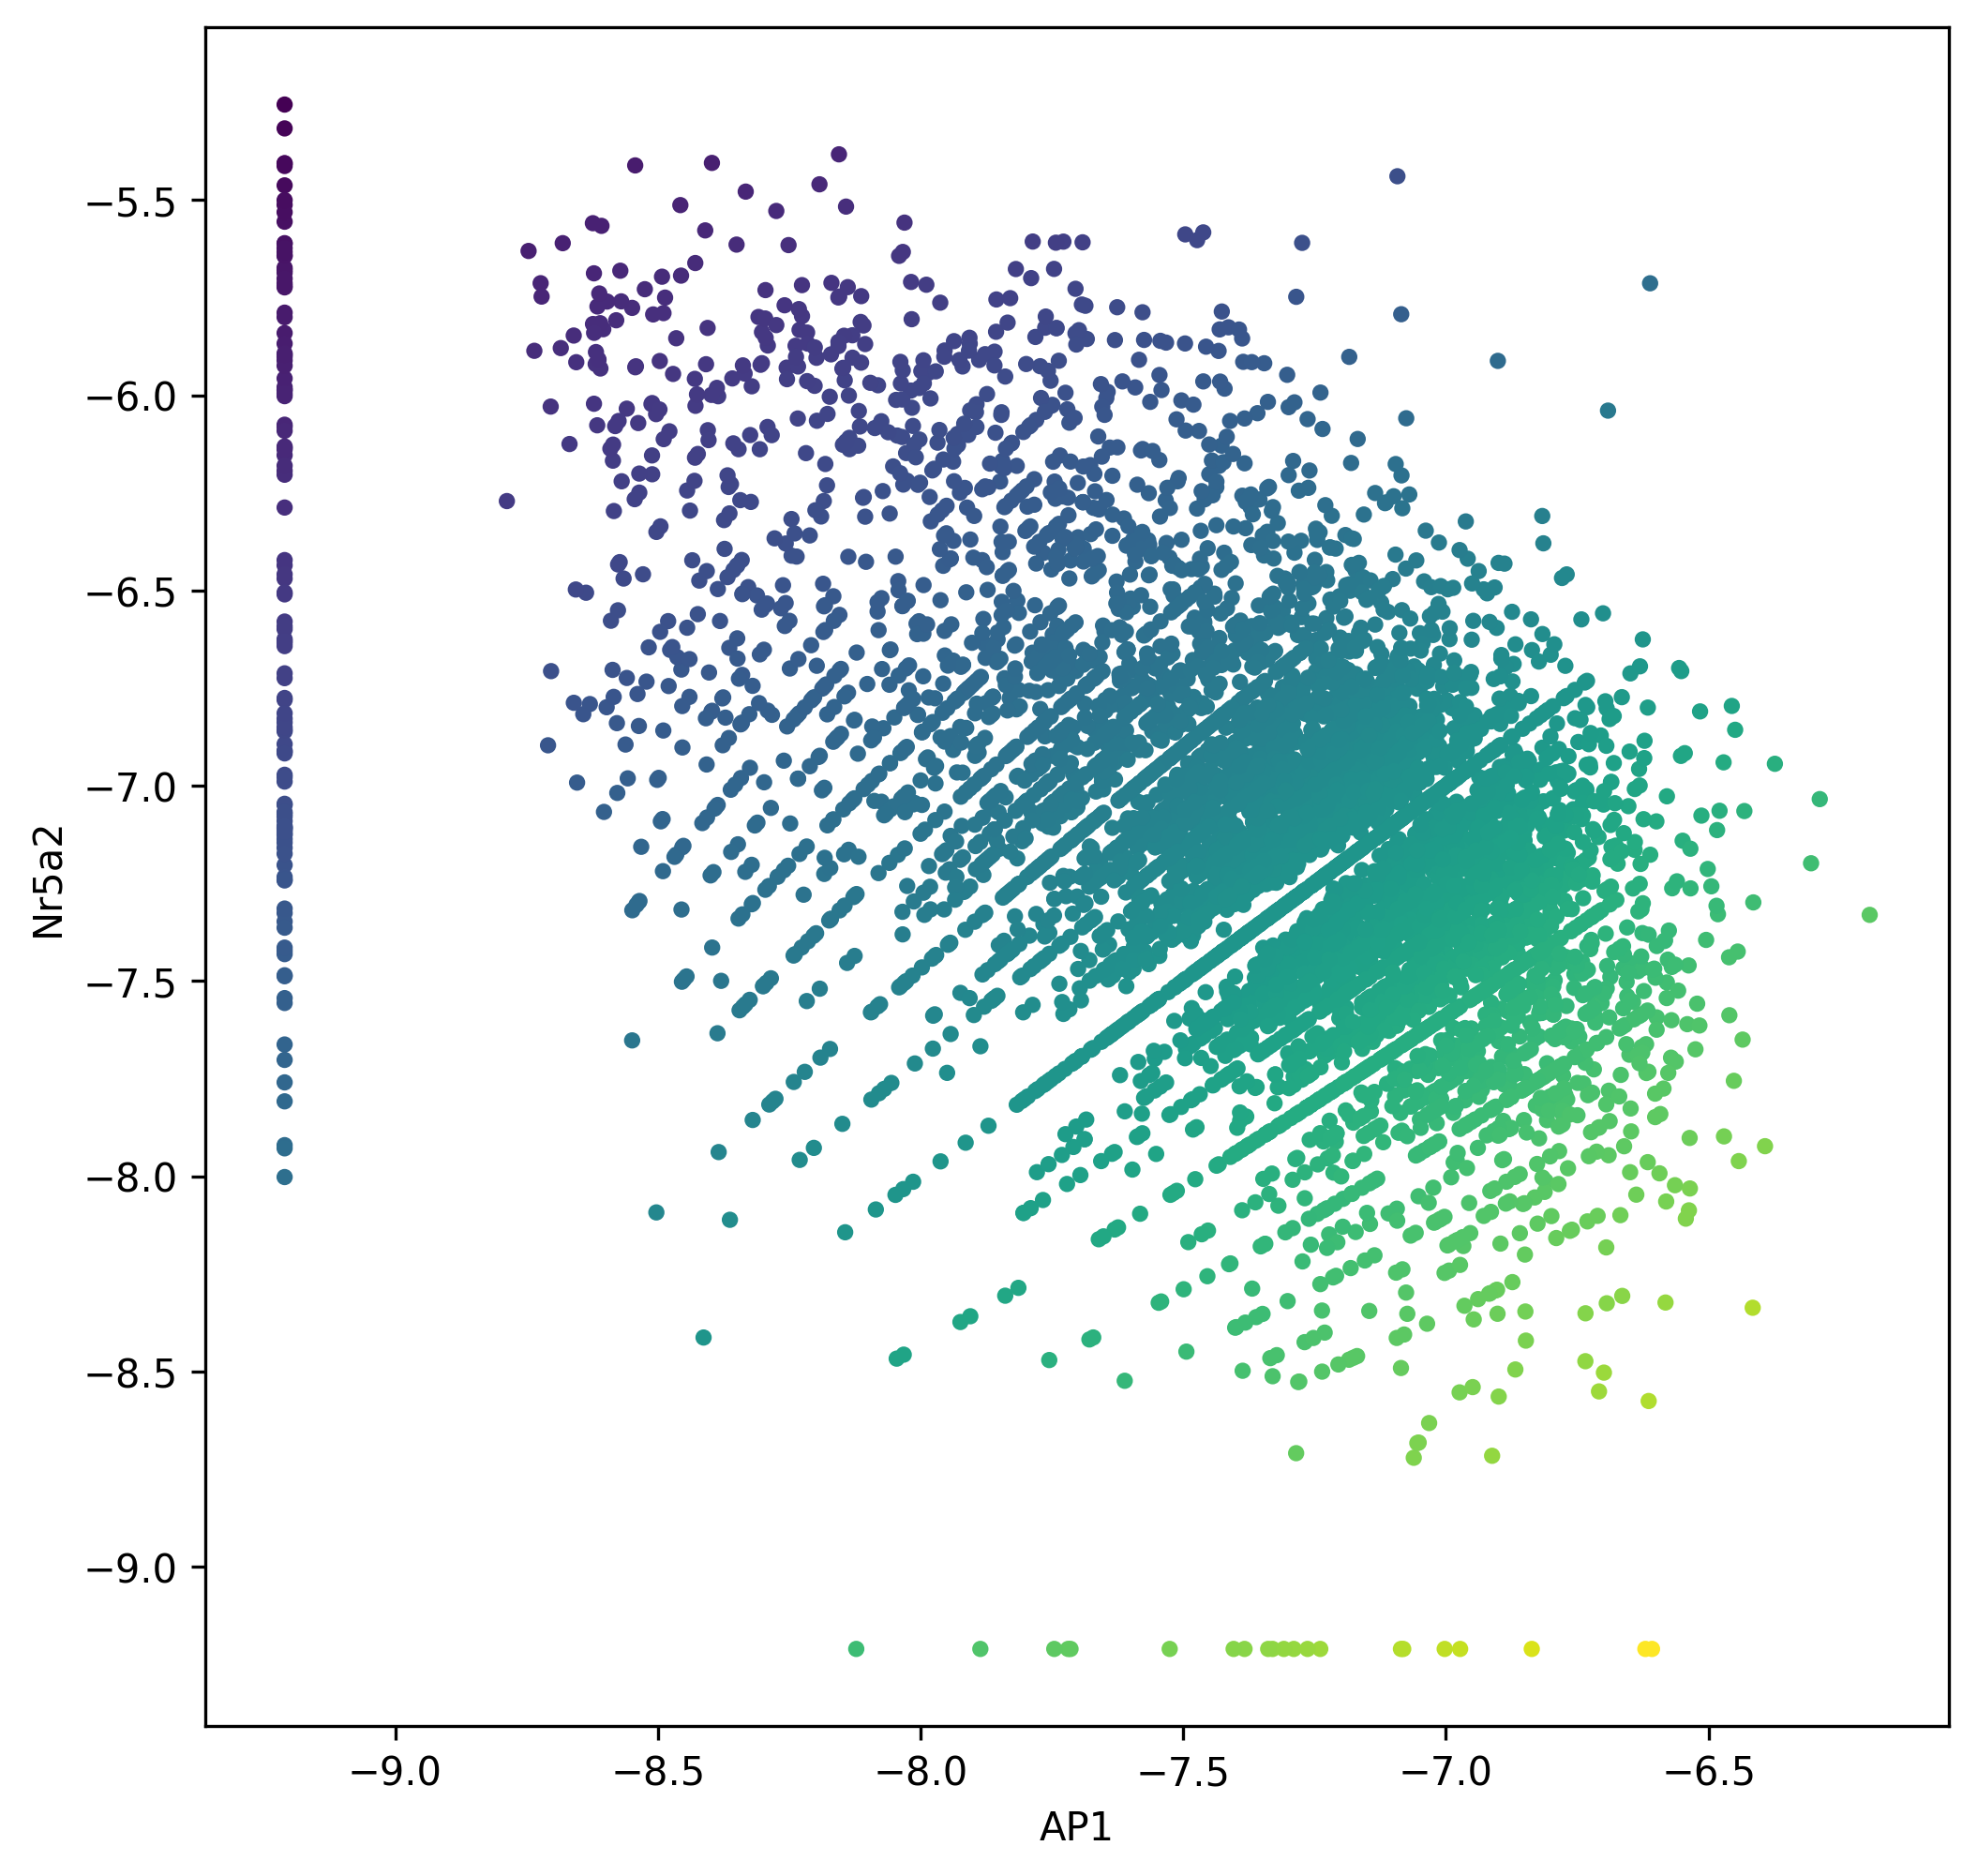

In [21]:
#re-plotting coloring by score to ensure it goes the way we expect
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(tmp2,tmp3,s=10,c=score,cmap='viridis')
ax.set_xlabel("AP1")
ax.set_ylabel("Nr5a2")

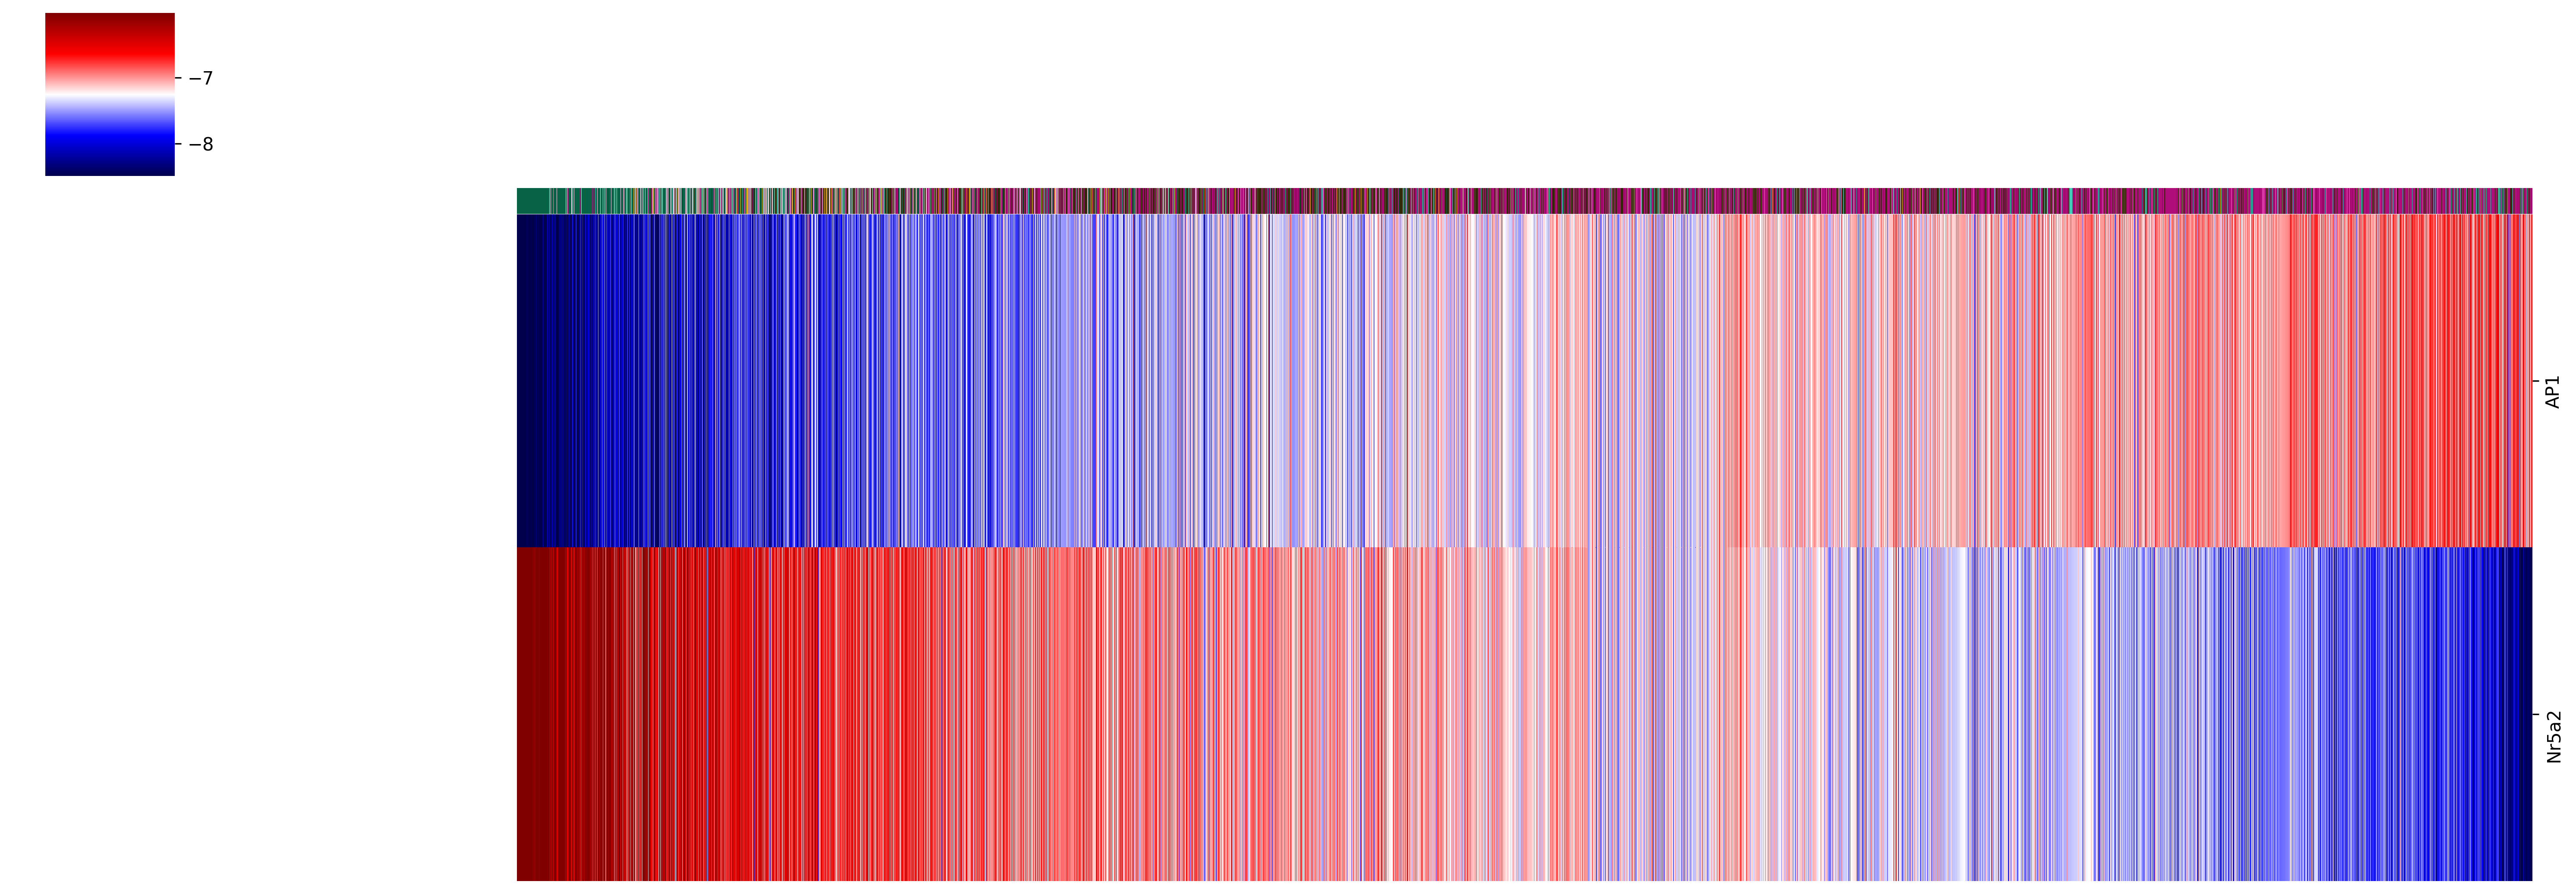

In [22]:
#orders peaks by increasing Ap1/Nr5a2 ratio
sns.clustermap(mat[:,order],row_cluster=False,col_cluster=False,
             xticklabels="",figsize=(20,7),vmin=np.percentile(mat,2),vmax=np.percentile(mat,98),
              yticklabels=["AP1",'Nr5a2'],cmap='seismic',
               col_colors=np.array(cells_clustersmerged_colors)[order])


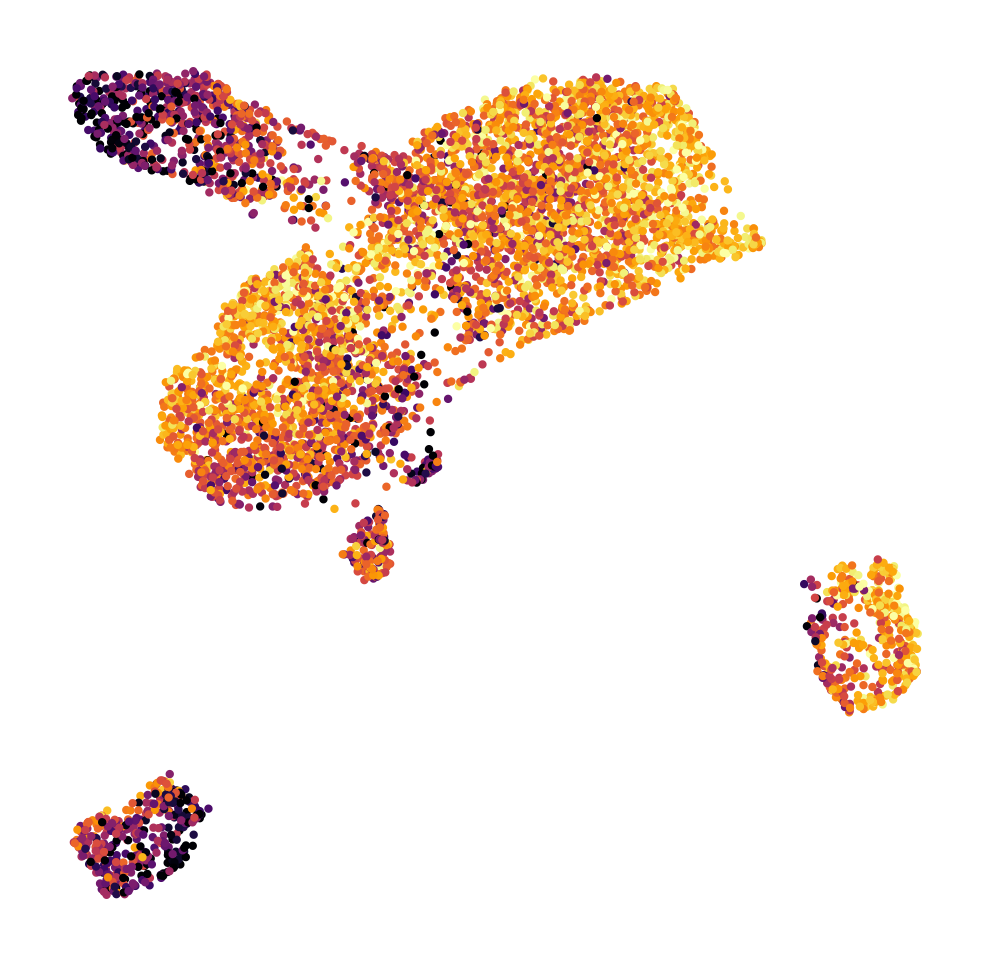

In [23]:
#AP1
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c=mat[0,:],cmap='inferno',vmax=np.percentile(mat[0,:],97),
           vmin=np.percentile(mat[0,:],3))
ax.set_axis_off()

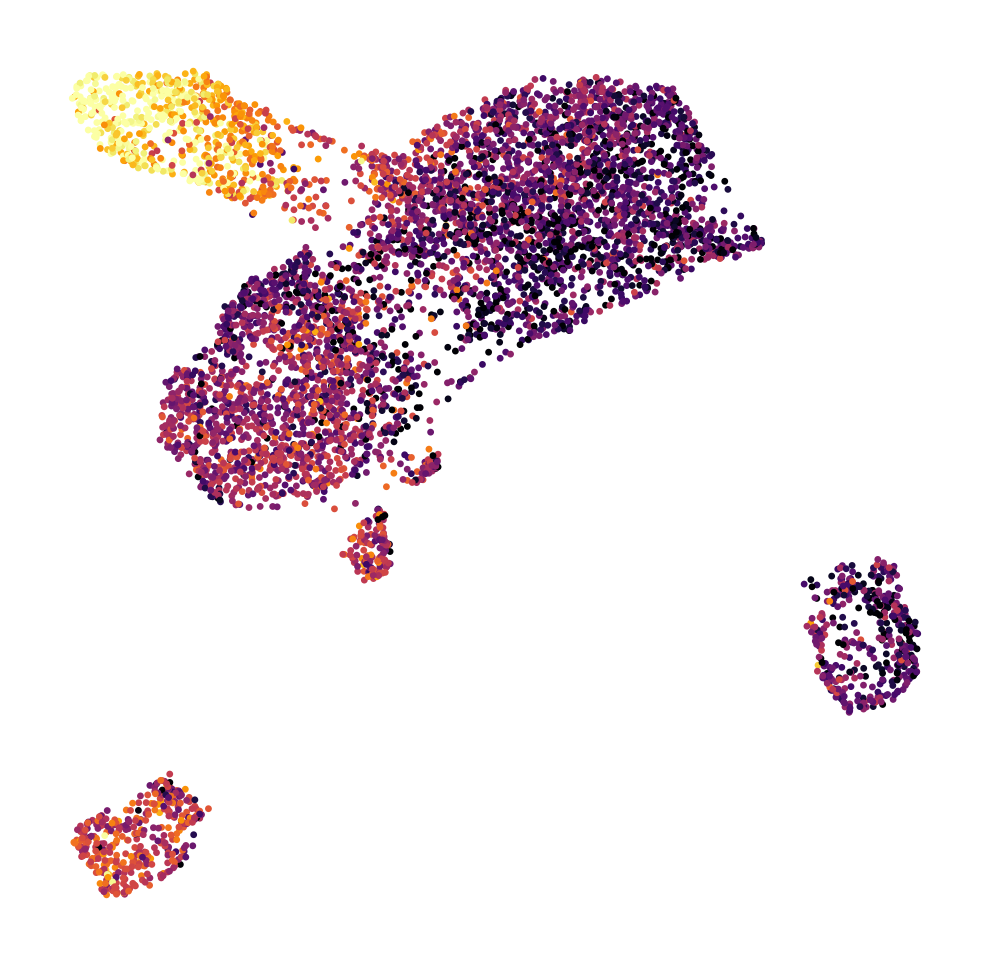

In [24]:
#Nr5a2
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(embedding[:,0],embedding[:,1],s=.4, c=mat[1,:],cmap='inferno',vmax=np.percentile(mat[1,:],97),
           vmin=np.percentile(mat[1,:],7))
ax.set_axis_off()